# Use Examples for sandiegodata.org-beachwatch

In [1]:
import matplotlib.pyplot as plt 
import metapack as mp
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [2]:
pkg = mp.jupyter.open_package()
pkg

,Column Name,Constant Value
0,program,BeachWatch
1,parentproject,BeachWatch_San Diego County
2,project,BeachWatch_San Diego County
3,locationcode,SurfZone
4,collectiondepth,-88
5,unitcollectiondepth,NR
6,sampletypecode,Grab
7,collectionreplicate,1
8,resultsreplicate,1
9,labsampleid,Not Recorded


In [3]:
pkg.resource('beachwatch')

Header,Type,Description
stationcode,string,Short name for the station
stationgroup,string,First two characters of station code
sampledate,datetime,Date sample was taken
collectiontime,time,Time sample was taken
measure_code,integer,"Reference to the measure codes, the unique groups of analyte, mehodname and unit."
analyte,string,"The type of bacterial being measured, for coliform, total coliform, Enterococcus or E. coli."
methodname,string,"Method used to count bacteria, such as “MTF”, “SM 9222 B” or “Enterolert”"
unit,string,"Measurement units, type of count per 100 ml."
result,integer,Measured value
result_group_count,integer,Number of records in this measurement group


In [4]:
beachwatch = pkg.resource('beachwatch').read_csv(parse_dates=True)
beachwatch.head()

,stationcode,stationgroup,sampledate,collectiontime,measure_code,analyte,methodname,unit,result,result_group_count,...,lresult_gt_lmedian,lresult_gt_lmean,lresult_lte_25pctl,lresult_gte_75pctl,labbatch,resultqualcode,qacode,sampleagency,labagency,submittingagency
0,EH-010,EH,1999-05-26,2018-08-08,0,"Coliform, Fecal",MTF,MPN/100 mL,20.0,213,...,0.0,0.0,0.0,1.0,SH-5/26/1999,<,NR,SDCDEH,SDCDEH,SDCDEH
1,EH-010,EH,1999-10-13,2018-08-08,0,"Coliform, Fecal",MTF,MPN/100 mL,0.0,213,...,0.0,0.0,0.0,0.0,SH-10/13/1999,=,NR,SDCDEH,SDCDEH,SDCDEH
2,EH-010,EH,1999-10-26,2018-08-08,0,"Coliform, Fecal",MTF,MPN/100 mL,20.0,213,...,0.0,0.0,0.0,1.0,SH-10/26/1999,<,NR,SDCDEH,SDCDEH,SDCDEH
3,EH-010,EH,2000-03-21,2018-08-08,0,"Coliform, Fecal",MTF,MPN/100 mL,20.0,213,...,0.0,0.0,0.0,1.0,SH-3/21/2000,<,NR,SDCDEH,SDCDEH,SDCDEH
4,EH-010,EH,2000-05-24,2018-08-08,0,"Coliform, Fecal",MTF,MPN/100 mL,230.0,213,...,1.0,1.0,0.0,1.0,SH-5/24/2000,=,NR,SDCDEH,SDCDEH,SDCDEH


In [5]:
beachwatch[['stationcode','measure_code','result_group_count', 'analyte','methodname','unit']]\
    .drop_duplicates()\
    .sort_values('result_group_count',ascending=False)\
    .head(10)

,stationcode,measure_code,result_group_count,analyte,methodname,unit
48745,EH-420,24,1081,Enterococcus,Enterolert,MPN/100 mL
75870,FM-010,24,990,Enterococcus,Enterolert,MPN/100 mL
110949,IB-080,24,980,Enterococcus,Enterolert,MPN/100 mL
164182,OC-100,24,963,Enterococcus,Enterolert,MPN/100 mL
87399,FM-100,24,918,Enterococcus,Enterolert,MPN/100 mL
9370,EH-060,24,902,Enterococcus,Enterolert,MPN/100 mL
6429,EH-050,24,896,Enterococcus,Enterolert,MPN/100 mL
40425,EH-380,24,881,Enterococcus,Enterolert,MPN/100 mL
197580,SE-060,24,824,Enterococcus,Enterolert,MPN/100 mL
47511,EH-420,11,771,"Coliform, Total",SM 9221 B,MPN/100 mL


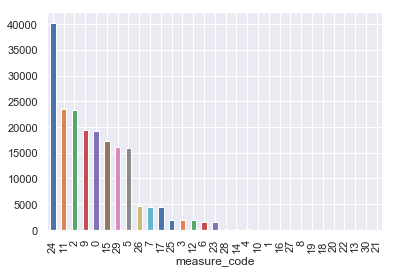

In [6]:
beachwatch.groupby('measure_code').count().result.sort_values(ascending=False).plot(kind='bar')

In [7]:
pkg.resource('measure_codes').read_csv().iloc[[24,11,2]]

,analyte,methodname,unit,measure_code
24,Enterococcus,Enterolert,MPN/100 mL,24
11,"Coliform, Total",SM 9221 B,MPN/100 mL,11
2,"Coliform, Fecal",SM 9221 E,MPN/100 mL,2


The most prevalent measure code in this dataset is 24 for Enterococcus (analyte) meaured with Enterolert (methodname) in units of MPN/100 mL. This is probably because in 2004, the [EPA changed recomendations to use Enterococcus as a primary indicator bacteria in coastal waters:](https://www.federalregister.gov/documents/2004/11/16/04-25303/water-quality-standards-for-coastal-and-great-lakes-recreation-waters)

    EPA subsequently recommended the use of E. coli or enterococci for fresh
    recreational waters and enterococci for marine recreational waters because
    levels of these organisms more accurately predict acute gastrointestinal
    illness than levels of fecal coliforms.
    
    

# Linear Regression, the Hard Way

In [8]:
# Get and join in the environmewntal dataset
env_pkg =  mp.open_package('http://library.metatab.org/sandiegodata.org-water_quality-4.zip')
trr = env_pkg.resource('tides_river_rain').read_csv(parse_dates=True).set_index('date')

df = beachwatch.set_index('sampledate').join(trr)


[0.33075766] 0.2459889553010444


/Users/eric/proj/virt/water/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Text(0,0.5,'> median')

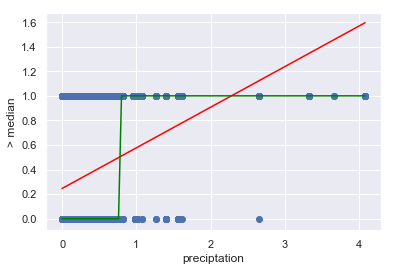

In [9]:
_1 = df[df.measure_code==24]

_2 = pd.DataFrame()

_2['y'] = _1.lresult_gt_lmedian 
_2['X'] = _1.recent_precip.fillna(0)

_2.sort_values('X', inplace=True)

# fit a linear regression model
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

linreg.fit(_2[['X']], _2['y'])

_2['predict_lin'] = linreg.predict(_2[['X']])
lr = _2

plt.scatter(lr['X'],lr['y'])
plt.plot(lr['X'],lr['predict_lin'], color='red')  

# Here is the decision line -- where the prediction linear line
# crosses .5
plt.plot(lr['X'], np.where(_2['predict_lin'] >= 0.5, 1, 0), color='green')
print(linreg.coef_, linreg.intercept_)
plt.xlabel('preciptation')
plt.ylabel('> median')


The blue dots are the points for precipitation, divied between those dates with results measurements above the median. THe red line is the regression line through the points, and the gree line is the decision line, which transitions from 0 to 1 when the regression line crosses .5.  

# Logistic Regression

Much of the sklearn examples come from: 

http://nbviewer.jupyter.org/github/justmarkham/DAT8/blob/master/notebooks/12_logistic_regression.ipynb

## Logistic Regression with sklearn

Here we tackle a similar problem to the linear regression  process, but instead use logistic regression. First we will use scikit's LogisticRegression to plot the class predictions curve, then the predictied prbabilities curve. 

In [10]:
# fit a logistic regression model and store the class predictions
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)

logreg.fit(lr[['X']], lr['y'])
lr['predict_log'] = logreg.predict(lr[['X']])


Here are the class redictions, which transitions from 0 to 1, as in the "hard way" example. 

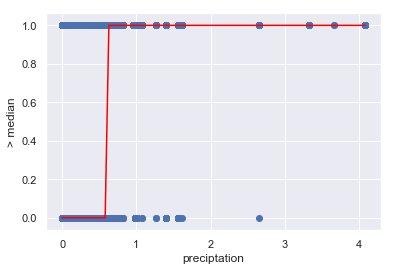

In [11]:
# plot the class predictions

plt.scatter(lr['X'],lr['y']) # The blue dots

plt.plot(lr['X'],lr['predict_log'], color='red') # The red line1
plt.xlabel('preciptation')
plt.ylabel('> median');

The predicted probabilities are usually an "S curve", with a left tail that asymptotically approches 0, and 1 on the right. The curve for this dataset is a bit wacked.   

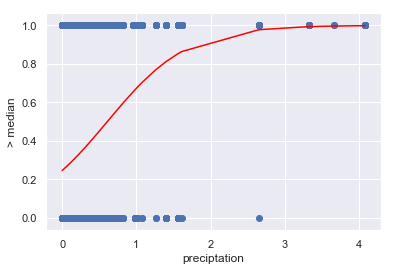

In [12]:
# store the predicted probabilites of class 1
lr['predict_prob'] = logreg.predict_proba(lr[['X']])[:, 1]

# plot the predicted probabilities
plt.scatter(lr['X'],lr['y'])

plt.plot(lr['X'],lr['predict_prob'], color='red')
plt.xlabel('preciptation')
plt.ylabel('> median');


Here are the coefficients, which we can compare to those of the statsmodel code in the next section. 

In [13]:
print("X coef={}, intercept={}".format(logreg.coef_[0], logreg.intercept_))

X coef=[1.84627449], intercept=[-1.12573655]


## Logistic Regression with statsmodel

In [14]:
# Function to set up the Logistic Regression run, and also
# Generate the odds ratio and confidence intervals

def logit(y,X):
    import statsmodels.api as sm

    X_ = pd.DataFrame()
   
    X_['X'] = X
    X_['const'] = 1

    logit_model=sm.Logit(y,X_)
    result=logit_model.fit()
    print(result.summary())

    # Odds ratio and confidence interval
    params = result.params
    conf = result.conf_int()
    conf['OR'] = params
    conf.columns = ['2.5%', '97.5%', 'OR']
    print(np.exp(conf))

In [15]:
logit(lr['y'],lr['X'])

Optimization terminated successfully.
         Current function value: 0.558891
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40349
Model:                          Logit   Df Residuals:                    40347
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Aug 2018   Pseudo R-squ.:                 0.01177
Time:                        13:25:56   Log-Likelihood:                -22551.
converged:                       True   LL-Null:                       -22819.
                                        LLR p-value:                8.516e-119
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.8463      0.093     19.876      0.000       1.664       2.028
const         -1.1257      0.

Awesome! The coefficients  for this  regression are the same as those for #12. 

# Other Stuff

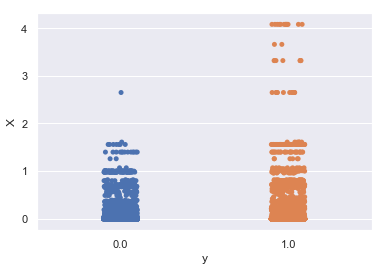

In [16]:
sns.stripplot(y=lr['X'],x=lr['y'])

# Crosstabs

In [17]:
(pd.crosstab(_1.lresult_gt_lmean, _1.recent_precip.fillna(0) > 0, margins=True, normalize='all')*100).round(2)

recent_precip,False,True,All
lresult_gt_lmean,,,
0.0,73.15,3.46,76.61
1.0,21.18,2.22,23.39
All,94.32,5.68,100.00
